In [482]:
import pandas as pd
import numpy as np
import umap
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import synapseclient

syn = synapseclient.Synapse()
syn.login()

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["pdf.fonttype"] = 42

Welcome, Clemens Hug!



## Download data

In [24]:
cell_tensor = syn.get("syn25931643").path
cell_tensor = np.load(cell_tensor)

encodings = syn.get("syn25931756").path
encodings = pd.read_csv(encodings, header=None)

cell_data = syn.get("syn25931638").path
cell_data = pd.read_csv(cell_data)

In [25]:
cell_data

,cell_ix,Reg,tile_y,tile_x,tile_z,cell_tile_y,cell_tile_x,Absolute Y,Absolute X,Cell Size,...,segf241_UNcomp,segf242_UNcomp,segf243_UNcomp,segf244_UNcomp,segf251_UNcomp,segf252_UNcomp,segf253_UNcomp,segf254_UNcomp,manual_annotation_1,manual_annotation_2
0,80,5,1,1,11,701.324324,261.054054,701,261,186,...,11783.215054,11783.215054,12866.064516,12866.064516,6182.258065,6182.258065,7117.930108,7117.930108,0.0,0
1,212,5,1,1,11,716.507692,264.353846,717,264,140,...,12921.900000,12921.900000,11500.878571,11500.878571,6286.750000,6286.750000,3635.735714,3635.735714,0.0,0
2,219,5,1,1,11,705.239583,276.666667,705,277,223,...,13242.367713,13242.367713,12989.067265,12989.067265,6563.331839,6563.331839,4254.322870,4254.322870,4.0,0
3,122,5,2,1,10,13.150538,283.225806,733,283,189,...,12770.460317,12770.460317,15337.449735,15337.449735,5986.857143,5986.857143,13440.227513,13440.227513,0.0,0
4,128,5,2,1,10,32.719298,135.298246,753,135,154,...,11859.629870,11859.629870,11903.779221,11903.779221,5830.935065,5830.935065,3637.285714,3637.285714,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3218,1034,5,9,7,7,149.500000,327.500000,4398,4648,104,...,12443.750000,12443.750000,5417.317308,5417.317308,8798.076923,8798.076923,3050.740385,3050.740385,0.0,0
3219,1038,5,9,7,7,162.500000,284.000000,4410,4604,114,...,15303.359649,15303.359649,8483.333333,8483.333333,10606.140351,10606.140351,4025.622807,4025.622807,5.0,0
3220,1096,5,9,7,7,87.043478,662.594203,4335,4983,120,...,10493.133333,10493.133333,11068.891667,11068.891667,10602.808333,10602.808333,9967.466667,9967.466667,4.0,1
3221,1099,5,9,7,7,492.673913,319.717391,4741,4640,106,...,14141.981132,14141.981132,13393.179245,13393.179245,11416.301887,11416.301887,14836.141509,14836.141509,0.0,0


In [82]:
cell_tensor.shape

(3223, 100, 32, 32)

## UMAP embedding

In [54]:
umap_obj = umap.UMAP(
    init="spectral", n_neighbors=50, min_dist=0.1,
    metric="manhattan"
)

In [55]:
umap_obj.fit(np.array(encodings))

UMAP(dens_frac=0.0, dens_lambda=0.0, metric='manhattan', n_neighbors=50)

In [56]:
embedding = umap_obj.transform(np.array(encodings))

<AxesSubplot:>

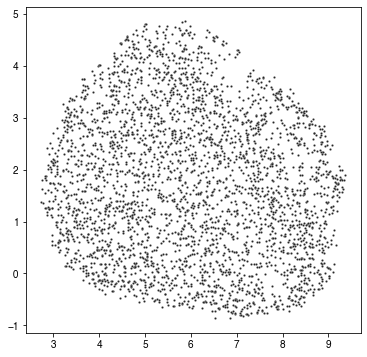

In [271]:
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], s=5, color=".15")

## Visualize average PD-1 signal

In [352]:
x_thresholds = np.array([float("-Inf"), 5, 7, float("Inf")])
y_thresholds = np.array([float("-Inf"), 1, 3, float("Inf")])

In [353]:
x_thresholds = np.linspace(min(embedding[:, 0]), max(embedding[:, 0]), num=5)
y_thresholds = np.linspace(min(embedding[:, 1]), max(embedding[:, 1]), num=5)

In [354]:
x_thresholds

array([2.72573137, 4.38689363, 6.04805589, 7.70921814, 9.3703804 ])

In [355]:
np.digitize(embedding[:, 1], bins=y_thresholds).max()

5

In [365]:
x_bins = np.digitize(embedding[:, 0], bins=x_thresholds) - 1
y_bins = np.digitize(embedding[:, 1], bins=y_thresholds) - 1
bin_df = pd.DataFrame(dict(x_bin=x_bins, y_bin=y_bins))
bin_df["position"] = bin_df["x_bin"] + 4*bin_df["y_bin"]

In [366]:
np.unique(x_bins)

array([0, 1, 2, 3, 4])

In [367]:
np.unique(y_bins)

array([0, 1, 2, 3, 4])

In [368]:
bin_df.groupby(["x_bin", "y_bin", "position"]).size()

x_bin  y_bin  position
0      0      0           127
       1      4           269
       2      8           221
       3      12           55
1      0      1           229
       1      5           263
       2      9           275
       3      13          250
       4      17            1
2      0      2           265
       1      6           242
       2      10          283
       3      14          102
3      0      3           196
       1      7           268
       2      11          161
       3      15           15
4      1      8             1
dtype: int64

In [369]:
# cell_tensor_binned = {
#     (row.x_bin, row.y_bin):
#         cell_tensor[bin_df["x_bin"] == row.x_bin & bin_df["y_bin"] == row.y_bin, ...] for row in bin_df.drop_duplicates().itertuples(index=False)
# }
cell_tensor_binned = {
    pos:
        cell_tensor[bin_df["position"] == pos, ...] for pos in range(16)
}

In [370]:
cell_tensor_binned.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [371]:
cell_tensor_binned_pd1_mean = {
    pos: np.mean(cells[:, 39, ...], axis=0) for pos, cells in cell_tensor_binned.items()
}

In [372]:
4 % 3

1

(3, 0)
(3, 1)
(3, 2)
(3, 3)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(0, 0)
(0, 1)
(0, 2)
(0, 3)


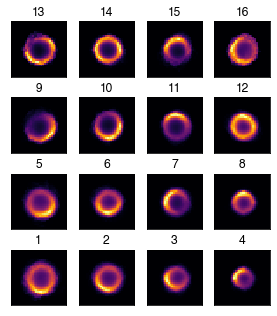

In [477]:
fig, axes = plt.subplots(figsize=(4.5, 4.5), nrows=4, ncols=4)

for pos, cells in cell_tensor_binned.items():
    x_pos, y_pos = 3 - pos // 4, pos % 4
    print((x_pos, y_pos))
    cell_mean = np.mean(
        cells[:, 39, ...], axis=0, 
    )
    ax = axes[x_pos][y_pos]
    ax.imshow(cell_mean, cmap="inferno", interpolation="none")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(pos + 1)

fig.tight_layout(h_pad=0.2, w_pad=-3)

In [478]:
fig.savefig("pd1_signal_per_cluster.pdf")

Sanity test that we're getting the right cluster numbering

In [410]:
test = (embedding[:, 0] > 7.8) & (embedding[:, 1] > 2) & (embedding[:, 1] < 3.5)

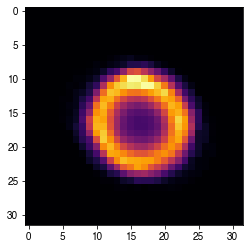

In [411]:
plt.imshow(
    np.mean(cell_tensor[test, 39, ...], axis=0), cmap = "inferno"
)

## Visualize UMAP

In [412]:
cell_data["PD1_UNcomp"]

0       3099.505376
1       9303.914286
2       8603.852018
3       3886.227513
4       4582.558442
           ...     
3218    2830.009615
3219    6469.482456
3220    5085.008333
3221    3325.584906
3222    4345.338462
Name: PD1_UNcomp, Length: 3223, dtype: float64

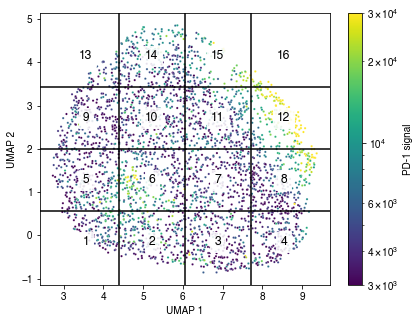

In [528]:
fig, ax = plt.subplots(figsize=(6.5, 5))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    s=5,
    c=cell_data["PD1_UNcomp"],
    legend="full",
    ax=ax,
    norm=matplotlib.colors.LogNorm(vmin=3000, vmax=30000)
)
norm = matplotlib.colors.LogNorm(3000, 30000)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, label="PD-1 signal")

ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
for t in y_thresholds[1:-1]:
    ax.axhline(t, color="black")
for t in x_thresholds[1:-1]:
    ax.axvline(t, color="black")
for pos in range(16):
    x, y = pos % 4, pos // 4
#     print(
#         np.mean(x_thresholds[[x, x + 1]]),
#         np.mean(x_thresholds[[y, y + 1]]),
#     )
#     ax.scatter(
#         x=np.mean(x_thresholds[[x, x + 1]]),
#         y=np.mean(y_thresholds[[y, y + 1]]),
#         color="#FFFFFFEE",
# #         color="red",
#         s=300
#     )
    ax.text(
        x=np.mean(x_thresholds[[x, x + 1]]),
        y=np.mean(y_thresholds[[y, y + 1]]),
#         x=x_thresholds[x + 1],
#         y=y_thresholds[y],
        s=pos + 1,
        fontsize=12,
        fontweight="bold",
        color="black",
        backgroundcolor="#FFFFFFDD",
        ha="center", va="center"
#         ha="right", va="bottom"
    )

In [529]:
fig.savefig("pd1_embedding_with_clusters.pdf")